## Boston Housing Price Prediction

In [2]:
import mlflow

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
print("Successfully set MLFlow Server Path")

Successfully set MLFlow Server Path


In [31]:
## Reload module

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We will be using the boston housing price dataset. There are 14 attributes in each case of the dataset. They are:

- CRIM - per capita crime rate by town
- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS - proportion of non-retail business acres per town.
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX - nitric oxides concentration (parts per 10 million)
- RM - average number of rooms per dwelling
- AGE - proportion of owner-occupied units built prior to 1940
- DIS - weighted distances to five Boston employment centres
- RAD - index of accessibility to radial highways
- TAX - full-value property-tax rate per 10,000 dollars
- PTRATIO - pupil-teacher ratio by town
- B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT - % lower status of the population
- MEDV - Median value of owner-occupied homes in $1000's

Have a look here for reference of this dataset: https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

In [51]:
from src.models.boston_house_price_prediction import env
from src.models.boston_house_price_prediction import train_model


boston = train_model.load_data(data_dir=env.data_dir)
if boston is not None:
    print("******* Successfully loaded boston data ********")
else:
    print("Boston data is not loaded.")
    raise Exception()

Dataset file: /home/joesan/Projects/Private/ml-projects/nn-playground/data/raw/boston_housing_price/boston_housing.csv
Dataset file exists.
******* Successfully loaded boston data ********


In [53]:
# Let us describe the data
print(boston.describe())

             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.1057

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [58]:
# Extracting features (first 12 columns)
import pandas as pd

# Extracting features (first 12 columns) as a DataFrame
X = boston.iloc[:, :-1]

# Extracting target variable (last column) as a Series
y = boston.iloc[:, -1]

# Step 0: Let us do some data visualization

We first do some data visualization to decide on how we should do data cleansing and feature engineering.

Text(0, 0.5, 'MEDV')

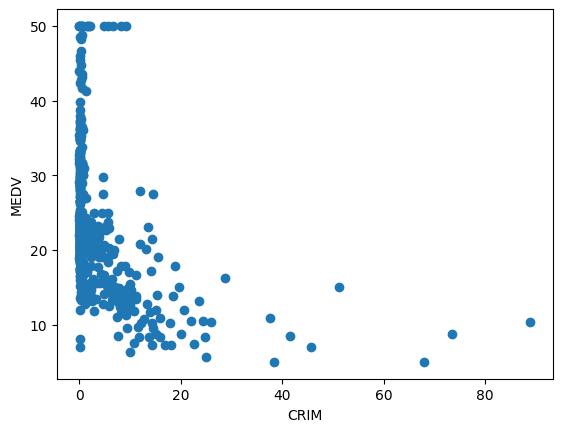

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from pandas.plotting import scatter_matrix


# scatter plot
plt.scatter(boston['CRIM'], boston['MEDV'])
plt.xlabel("CRIM")
plt.ylabel("MEDV")


# Step 1: Basic Data Cleansing

In [68]:
# Delete unique columns & delete duplicate rows
from src.models.boston_house_price_prediction import cleanse_data

boston_delete_unique_columns = cleanse_data.delete_unique_columns(boston)
boston_delete_duplicate_rows = cleanse_data.delete_duplicate_rows(boston_delete_unique_columns)

************+ delete_unique_columns ************+ 
Shape of boston before deleting columns with unique values: (506, 14)
Are there any columns with unique values? False
************+ delete_unique_columns ************+ 
************+ delete_duplicate_rows ************+ 
Shape of boston before deleting duplicated rows: (506, 14)
Are there any duplicate rows? False
************+ delete_duplicate_rows ************+ 


In [55]:
# Summarize the number of unique values in each column and calculate the percentage of the total number of rows in the dataset
for index, column in enumerate(boston.columns):
    num_unique = boston[column].nunique()
    percentage = (num_unique / boston.shape[0]) * 100
    if percentage < 1:
        print(f'Index: {index}, Column: {column}, Unique Values: {num_unique}, Percentage: {percentage:.1f}%')

Index: 3, Column: CHAS, Unique Values: 2, Percentage: 0.4%


In [10]:
# Handling missing data

# Summarize the number of rows with missing values for each column
for column in boston.columns:
    # Count number of rows with missing values
    n_miss = boston[column].isnull().sum()
    perc = n_miss / boston.shape[0] * 100
    print(f' > {column}, Missing: {n_miss} ({perc:.1f}%)')

 > CRIM, Missing: 0 (0.0%)
 > ZN, Missing: 0 (0.0%)
 > INDUS, Missing: 0 (0.0%)
 > CHAS, Missing: 0 (0.0%)
 > NOX, Missing: 0 (0.0%)
 > RM, Missing: 0 (0.0%)
 > AGE, Missing: 0 (0.0%)
 > DIS, Missing: 0 (0.0%)
 > RAD, Missing: 0 (0.0%)
 > TAX, Missing: 0 (0.0%)
 > PTRATIO, Missing: 0 (0.0%)
 > B, Missing: 0 (0.0%)
 > LSTAT, Missing: 0 (0.0%)
 > MEDV, Missing: 0 (0.0%)


# Step 2: Outlier Detection

CRIM: Not Gaussian  ShapiroResult(statistic=0.4499647802113227, pvalue=1.3285893795939685e-36)
CRIM: Not Gaussian  KstestResult(statistic=0.5025212984276741, pvalue=9.101764614072096e-119, statistic_location=0.00632, statistic_sign=-1)
ZN: Not Gaussian  ShapiroResult(statistic=0.5559466932042578, pvalue=7.882830475544967e-34)
ZN: Not Gaussian  KstestResult(statistic=0.5, pvalue=1.6871111181943794e-117, statistic_location=0.0, statistic_sign=-1)
INDUS: Not Gaussian  ShapiroResult(statistic=0.8997938834997923, pvalue=1.0646987056818077e-17)
INDUS: Not Gaussian  KstestResult(statistic=0.9382587138709638, pvalue=0.0, statistic_location=2.01, statistic_sign=-1)
CHAS: Not Gaussian  ShapiroResult(statistic=0.27476065687000795, pvalue=2.3505073051297636e-40)
CHAS: Not Gaussian  KstestResult(statistic=0.5, pvalue=1.6871111181943794e-117, statistic_location=0, statistic_sign=-1)
NOX: Not Gaussian  ShapiroResult(statistic=0.9356359807798653, pvalue=5.776225084930437e-14)
NOX: Not Gaussian  Kstest

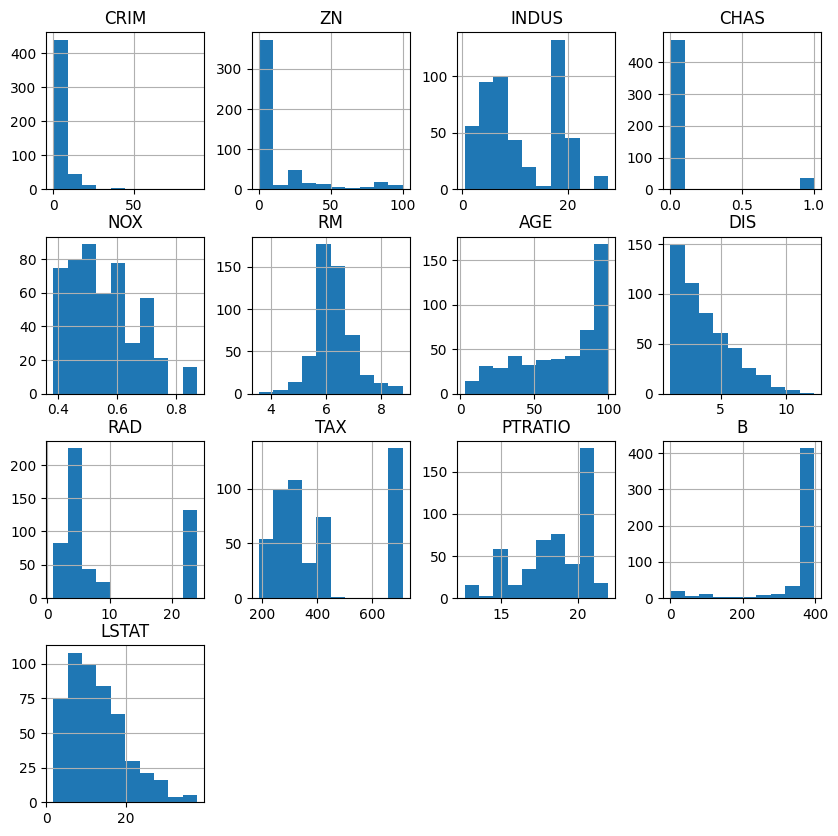

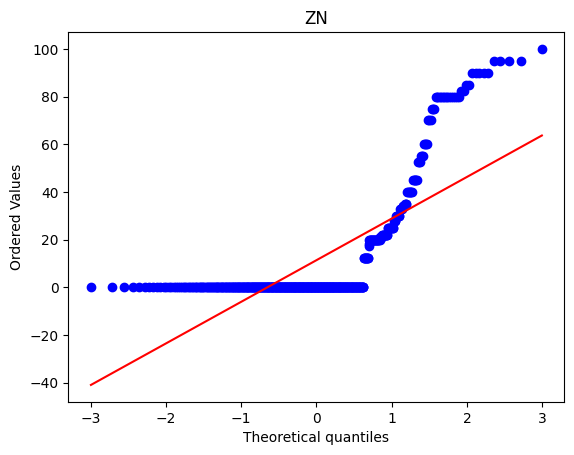

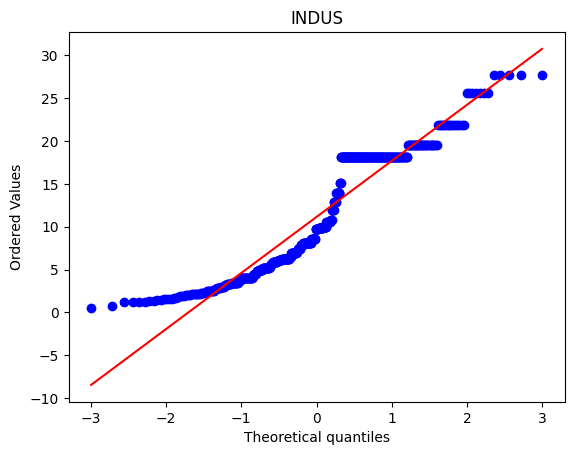

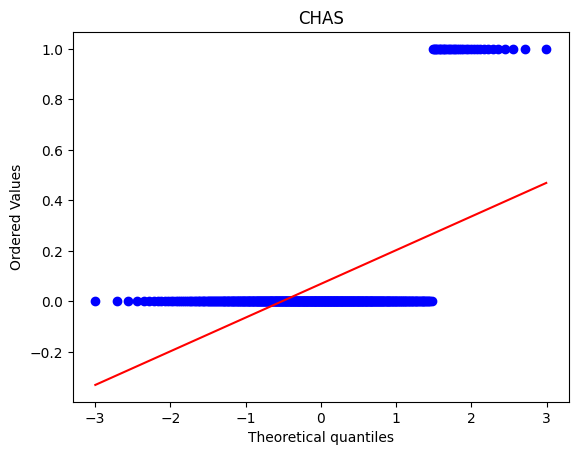

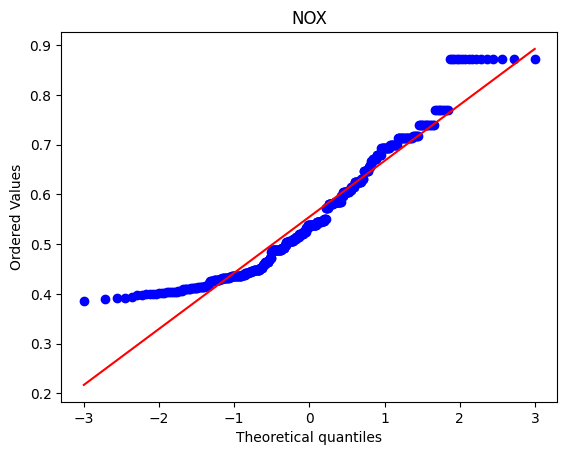

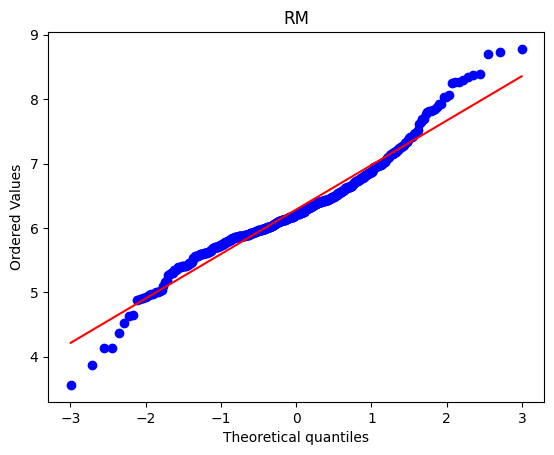

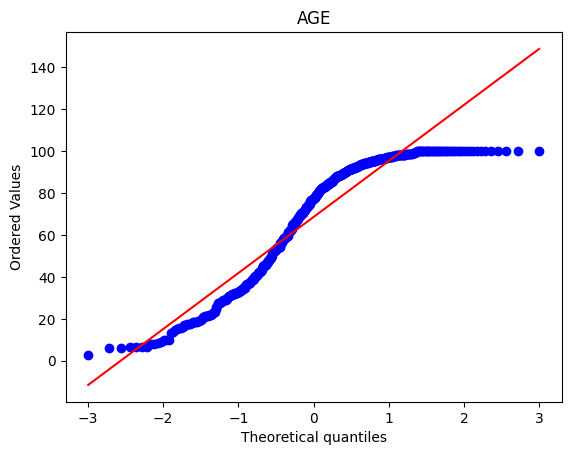

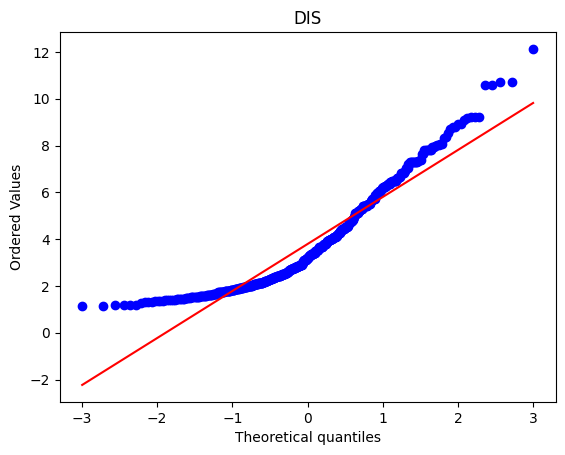

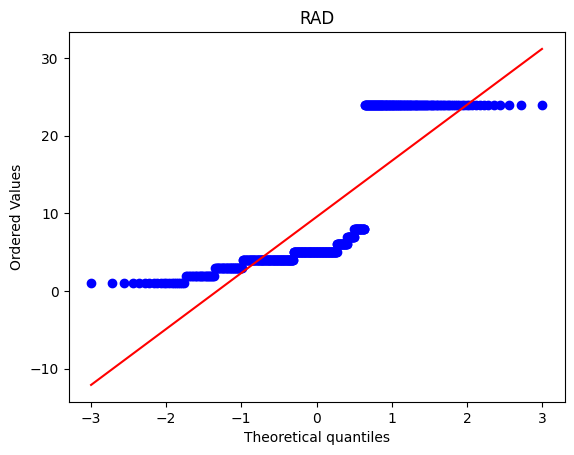

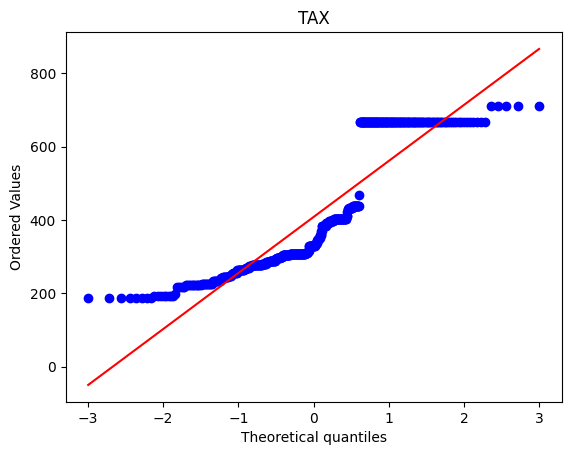

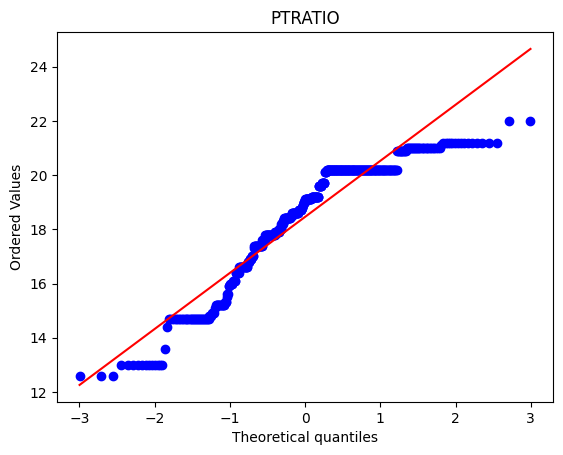

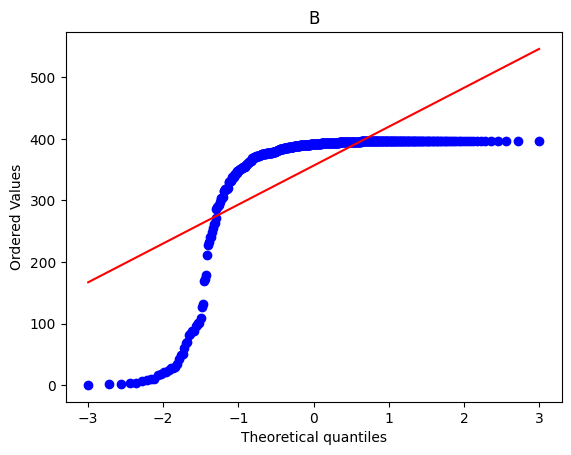

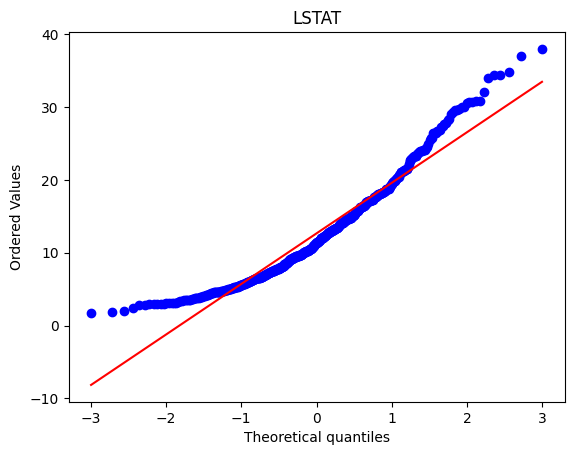

lower = -34.15, upper = 58.89


UFuncTypeError: ufunc 'greater' did not contain a loop with signature matching types (<class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.StrDType'>) -> None

In [67]:
X.hist(figsize=(10,10))

from scipy.stats import shapiro, kstest
from numpy import percentile

for i in X.columns:
    print(f'{i}: {"Not Gaussian" if shapiro(X[i])[1]<0.05 else "Gaussian"}  {shapiro(X[i])}')
    print(f'{i}: {"Not Gaussian" if kstest(X[i].values,"norm")[1]<0.05 else "Gaussian"}  {kstest(X[i].values,"norm")}')
    
from scipy.stats import probplot
import matplotlib.pyplot as plt
for i in X.columns:
    probplot(x=X[i],dist='norm',plot=plt)
    plt.title(i)
    plt.show()
    
# calculate interquartile range
q25, q75 = percentile(X, 25), percentile(X, 75)
iqr = q75 - q25
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
print(f"lower = {lower}, upper = {upper}")
outliers = [x for x in X if x < lower or x > upper]
print(f"outliers = {outliers}")

In [80]:
# Identify missing values
from src.models.boston_house_price_prediction import cleanse_data

missing_values = boston.isnull().sum()
print(f"missing_values = {missing_values}")
deleted_rows = cleanse_data.delete_missing_values(boston)

missing_values = CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64
************+ delete_missing_values ************+ 
Shape of boston before deleting rows with missing values: (506, 14)
	Column CRIM: Zeros = 0, NaNs = 0
	Column ZN: Zeros = 372, NaNs = 0
	Column INDUS: Zeros = 0, NaNs = 0
	Column CHAS: Zeros = 471, NaNs = 0
	Column NOX: Zeros = 0, NaNs = 0
	Column RM: Zeros = 0, NaNs = 0
	Column AGE: Zeros = 0, NaNs = 0
	Column DIS: Zeros = 0, NaNs = 0
	Column RAD: Zeros = 0, NaNs = 0
	Column TAX: Zeros = 0, NaNs = 0
	Column PTRATIO: Zeros = 0, NaNs = 0
	Column B: Zeros = 0, NaNs = 0
	Column LSTAT: Zeros = 0, NaNs = 0
	Column MEDV: Zeros = 0, NaNs = 0


In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((404, 13), (102, 13), (404,), (102,))

# Step 2: Feature Selection

We calculate the Person's co-relation co-efficient! The correlation coefficient, often denoted as r, measures the strength and direction of the linear relationship between two variables. It ranges from -1 to 1.

- **Positive Correlation (0 < r ≤ 1):** As one variable increases, the other variable tends to also increase.
  - **Perfect Positive Correlation (r = 1):** The variables increase in perfect proportion.
  - **Strong Positive Correlation (0.7 ≤ r < 1):** There is a strong relationship; as one variable increases, the other increases significantly.
  - **Moderate Positive Correlation (0.5 ≤ r < 0.7):** There is a moderate relationship; as one variable increases, the other tends to increase.
  - **Weak Positive Correlation (0 < r < 0.5):** There is a weak relationship; as one variable increases, the other increases slightly.

- **Negative Correlation (-1 ≤ r < 0):** As one variable increases, the other variable tends to decrease.
  - **Perfect Negative Correlation (r = -1):** The variables decrease in perfect proportion.
  - **Strong Negative Correlation (-1 < r ≤ -0.7):** There is a strong inverse relationship; as one variable increases, the other decreases significantly.
  - **Moderate Negative Correlation (-0.7 < r ≤ -0.5):** There is a moderate inverse relationship; as one variable increases, the other tends to decrease.
  - **Weak Negative Correlation (-0.5 < r < 0):** There is a weak inverse relationship; as one variable increases, the other decreases slightly.

- **No Correlation (r = 0):** There is no linear relationship between the variables.

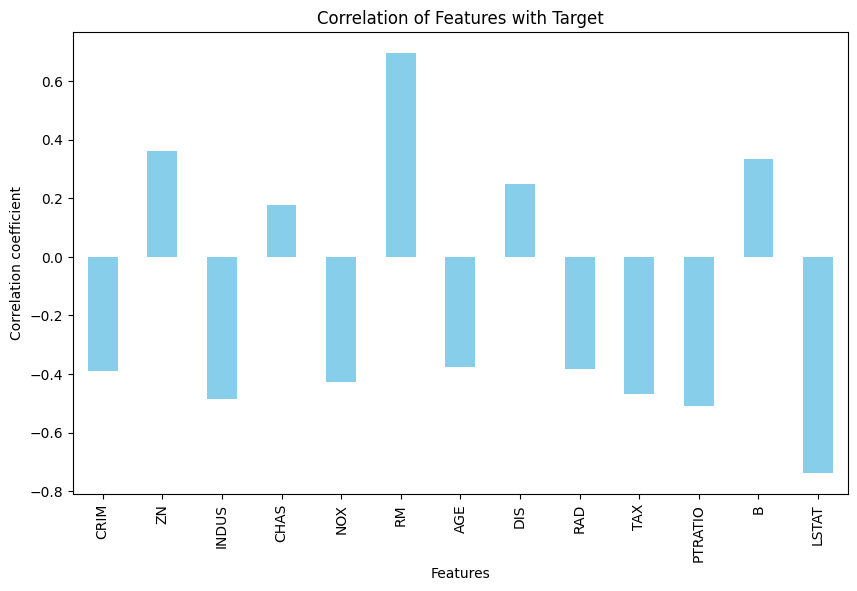

************+ delete_features_with_low_correlation ************+ 
Shape of boston before deleting features with low co-relation (506, 14)
Features with low correlation (|r| < 0.1): []
Shape of boston after deleting features with low co-relation: (506, 14)
************+ delete_features_with_low_correlation ************+ 


In [83]:
from src.models.boston_house_price_prediction.feature_selection import *
# Select features

# Compute the correlation matrix
correlation_matrix = boston.corr()
correlations_with_target = correlation_matrix['MEDV'].drop('MEDV')  # drop the correlation of the target with itself

# Plot the correlations
plt.figure(figsize=(10, 6))
correlations_with_target.plot(kind='bar', color='skyblue')
plt.title('Correlation of Features with Target')
plt.xlabel('Features')
plt.ylabel('Correlation coefficient')
plt.show()

df_reduced = delete_features_with_low_correlation(boston, 'MEDV')

In [85]:
# Summarize the number of rows with missing values for each column
for column in boston.columns:
    n_miss = boston[column].isnull().sum()
    perc = n_miss / boston.shape[0] * 100
    print(f' > {column}, Missing: {n_miss} ({perc:.1f}%)')

 > CRIM, Missing: 0 (0.0%)
 > ZN, Missing: 0 (0.0%)
 > INDUS, Missing: 0 (0.0%)
 > CHAS, Missing: 0 (0.0%)
 > NOX, Missing: 0 (0.0%)
 > RM, Missing: 0 (0.0%)
 > AGE, Missing: 0 (0.0%)
 > DIS, Missing: 0 (0.0%)
 > RAD, Missing: 0 (0.0%)
 > TAX, Missing: 0 (0.0%)
 > PTRATIO, Missing: 0 (0.0%)
 > B, Missing: 0 (0.0%)
 > LSTAT, Missing: 0 (0.0%)
 > MEDV, Missing: 0 (0.0%)
